<a href="https://colab.research.google.com/github/scottthomaswx/WarningPlotter/blob/main/Warning_Plotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Needed Code

In [1]:
# @title
#Install/Import Packages
%%capture
!pip install geopandas
!pip install metpy
!pip install requests
!pip install cartopy
!pip install matplotlib
!pip install numpy
import matplotlib.pyplot as plt
import geopandas
from metpy.plots import MapPanel, PanelContainer, PlotGeometry
import requests
import pandas as pd
from metpy.plots import USCOUNTIES
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import numpy as np

#Enter Information To Pull Needed Data

In [ ]:
# @markdown # WFO Selection
# @markdown ## Input the 3 digit WFO code or NA. At least one WFO must be added

WFO_1 = 'GRR' #@param {type:"string"}
WFO_2 = 'DTX' #@param {type:"string"}
WFO_3 = 'IWX' #@param {type:"string"}
WFO_4 = 'LOT' #@param {type:"string"}
WFO_5 = 'MKX' #@param {type:"string"}
WFO_6 = 'CLE' #@param {type:"string"}

# @markdown ## Input WFO(s) how you want them listed in the title

WFO_List = 'GRR/DTX/IWX/LOT/MKX/CLE' #@param {type:"string"}

# @markdown # Start and End Date/Time Selection
# @markdown ## Enter in the format YYYY-MM-DDT:HH:MM

Begins = '2024-02-27T12:00' #@param {type:"string"}
Ends = '2024-02-28T12:00' #@param {type:"string"}

WestLong = -89.5 # @param {type:"number"}
EastLong = -82.5 # @param {type:"number"}
NorthLat = 44.5 # @param {type:"number"}
SouthLat = 41.5 # @param {type:"number"}

#Pull Warnings and LSRs

In [ ]:
# @title
#Pull Warnings
try:
  Warn1 = geopandas.read_file('https://mesonet.agron.iastate.edu/api/1/cow.json?wfo='+WFO_1+'&begints='+Begins+':00Z&endts='+Ends+':00Z&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrtype=T&lsrtype=D&lsrtype=H&lsrtype=G&lsrtype=MA&lsrtype=FF&lsrtype=DS&lsrbuffer=15&warningbuffer=1')
except:
  pass
try:
  Warn2 = geopandas.read_file('https://mesonet.agron.iastate.edu/api/1/cow.json?wfo='+WFO_2+'&begints='+Begins+':00Z&endts='+Ends+':00Z&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrtype=T&lsrtype=D&lsrtype=H&lsrtype=G&lsrtype=MA&lsrtype=FF&lsrtype=DS&lsrbuffer=15&warningbuffer=1')
except:
  pass
try:
  Warn3 = geopandas.read_file('https://mesonet.agron.iastate.edu/api/1/cow.json?wfo='+WFO_3+'&begints='+Begins+':00Z&endts='+Ends+':00Z&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrtype=T&lsrtype=D&lsrtype=H&lsrtype=G&lsrtype=MA&lsrtype=FF&lsrtype=DS&lsrbuffer=15&warningbuffer=1')
except:
  pass
try:
  Warn4 = geopandas.read_file('https://mesonet.agron.iastate.edu/api/1/cow.json?wfo='+WFO_4+'&begints='+Begins+':00Z&endts='+Ends+':00Z&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrtype=T&lsrtype=D&lsrtype=H&lsrtype=G&lsrtype=MA&lsrtype=FF&lsrtype=DS&lsrbuffer=15&warningbuffer=1')
except:
  pass
try:
  Warn5 = geopandas.read_file('https://mesonet.agron.iastate.edu/api/1/cow.json?wfo='+WFO_5+'&begints='+Begins+':00Z&endts='+Ends+':00Z&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrtype=T&lsrtype=D&lsrtype=H&lsrtype=G&lsrtype=MA&lsrtype=FF&lsrtype=DS&lsrbuffer=15&warningbuffer=1')
except:
  pass
try:
  Warn6 = geopandas.read_file('https://mesonet.agron.iastate.edu/api/1/cow.json?wfo='+WFO_6+'&begints='+Begins+':00Z&endts='+Ends+':00Z&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrtype=T&lsrtype=D&lsrtype=H&lsrtype=G&lsrtype=MA&lsrtype=FF&lsrtype=DS&lsrbuffer=15&warningbuffer=1')
except:
  pass
#Pull LSRs
try:
  LSR1 = 'https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]='+WFO_1+'&sts='+Begins+'Z&ets='+Ends+'Z&fmt=csv'
  LSR1File=pd.read_csv(LSR1)
except:
  pass
try:
  LSR2 = 'https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]='+WFO_2+'&sts='+Begins+'Z&ets='+Ends+'Z&fmt=csv'
  LSR2File=pd.read_csv(LSR2)
except:
  pass
try:
  LSR3 = 'https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]='+WFO_3+'&sts='+Begins+'Z&ets='+Ends+'Z&fmt=csv'
  LSR3File=pd.read_csv(LSR3)
except:
  pass
try:
  LSR4 = 'https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]='+WFO_4+'&sts='+Begins+'Z&ets='+Ends+'Z&fmt=csv'
  LSR4File=pd.read_csv(LSR4)
except:
  pass
try:
  LSR5 = 'https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]='+WFO_5+'&sts='+Begins+'Z&ets='+Ends+'Z&fmt=csv'
  LSR5File=pd.read_csv(LSR5)
except:
  pass
try:
  LSR6 = 'https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]='+WFO_6+'&sts='+Begins+'Z&ets='+Ends+'Z&fmt=csv'
  LSR6File=pd.read_csv(LSR6)
except:
  pass
#Add Marine Zones for Great Lakes
mzone_file = geopandas.read_file('/vsicurl/https://github.com/scottthomaswx/WarningPlotter/raw/main/mz19se23.shp')

#Add Path for SPS File If Available or Comment Out

In [ ]:
SPSFile = geopandas.read_file('/content/sps_202402272200_202402281159.shp')

#Parse Warnings and LSRs

In [ ]:
# @title
try:
  TORWarn = Warn1.query('phenomena == "TO"')
  SVRWarn = Warn1.query('phenomena == "SV"')
  FFWWarn = Warn1.query('phenomena == "FF"')
  SMWWarn = Warn1.query('phenomena == "MA"')
  DSWWarn = Warn1.query('phenomena == "DS"')
except:
  pass
try:
  LSR1File['MAG'] = LSR1File['MAG'].replace('None', np.nan)
  LSR1File['MAG'] = LSR1File['MAG'].astype(float)
except:
  pass
try:
  TORSR = LSR1File.query('TYPECODE == "T"')
  FNCSR = LSR1File.query('TYPECODE == "C"')
  TSGSR = LSR1File.query('TYPECODE == "G" & MAG < 75')
  SIGTSGSR = LSR1File.query('TYPECODE == "G" & MAG >= 75')
  HALSR = LSR1File.query('TYPECODE == "H" & MAG < 2.0')
  SIGHALSR = LSR1File.query('TYPECODE == "H" & MAG >= 2.0')
  TSDSR = LSR1File.query('TYPECODE == "D"')
  RANSR = LSR1File.query('TYPECODE == "R"')
  FLDSR = LSR1File.query('TYPECODE == "E"')
  FFDSR = LSR1File.query('TYPECODE == "F"')
  LTGSR = LSR1File.query('TYPECODE == "L"')
  MTGSR = LSR1File.query('TYPECODE == "M"')
  WSTSR = LSR1File.query('TYPECODE == "W"')
  NTGSR = LSR1File.query('TYPECODE == "N"')
except:
  pass
try:
  TORWarn2 = Warn2.query('phenomena == "TO"')
  SVRWarn2 = Warn2.query('phenomena == "SV"')
  FFWWarn2 = Warn2.query('phenomena == "FF"')
  SMWWarn2 = Warn2.query('phenomena == "MA"')
  DSWWarn2 = Warn2.query('phenomena == "DS"')
except:
    pass
try:
  LSR2File['MAG'] = LSR2File['MAG'].replace('None', np.nan)
  LSR2File['MAG'] = LSR2File['MAG'].astype(float)
except:
  pass
try:
  TORSR2 = LSR2File.query('TYPECODE == "T"')
  FNCSR2 = LSR2File.query('TYPECODE == "C"')
  TSGSR2 = LSR2File.query('TYPECODE == "G"')
  TSGSR2 = LSR2File.query('TYPECODE == "G" & MAG < 75')
  SIGTSGSR2 = LSR2File.query('TYPECODE == "G" & MAG >= 75')
  HALSR2 = LSR2File.query('TYPECODE == "H" & MAG < 2.0')
  SIGHALSR2 = LSR2File.query('TYPECODE == "H" & MAG >= 2.0')
  TSDSR2 = LSR2File.query('TYPECODE == "D"')
  RANSR2 = LSR2File.query('TYPECODE == "R"')
  FLDSR2 = LSR2File.query('TYPECODE == "E"')
  FFDSR2 = LSR2File.query('TYPECODE == "F"')
  LTGSR2 = LSR2File.query('TYPECODE == "L"')
  MTGSR2 = LSR2File.query('TYPECODE == "M"')
  WSTSR2 = LSR2File.query('TYPECODE == "W"')
  NTGSR2 = LSR2File.query('TYPECODE == "N"')
except:
  pass
try:
  TORWarn3 = Warn3.query('phenomena == "TO"')
  SVRWarn3 = Warn3.query('phenomena == "SV"')
  FFWWarn3 = Warn3.query('phenomena == "FF"')
  SMWWarn3 = Warn3.query('phenomena == "MA"')
  DSWWarn3 = Warn3.query('phenomena == "DS"')
except:
  pass
try:
  LSR3File['MAG'] = LSR3File['MAG'].replace('None', np.nan)
  LSR3File['MAG'] = LSR3File['MAG'].astype(float)
except:
  pass
try:
  TORSR3 = LSR3File.query('TYPECODE == "T"')
  FNCSR3 = LSR3File.query('TYPECODE == "C"')
  TSGSR3 = LSR3File.query('TYPECODE == "G" & MAG < 75')
  SIGTSGSR3 = LSR3File.query('TYPECODE == "G" & MAG >= 75')
  HALSR3 = LSR3File.query('TYPECODE == "H" & MAG < 2.0')
  SIGHALSR3 = LSR3File.query('TYPECODE == "H" & MAG >= 2.0')
  TSDSR3 = LSR3File.query('TYPECODE == "D"')
  RANSR3 = LSR3File.query('TYPECODE == "R"')
  FLDSR3 = LSR3File.query('TYPECODE == "E"')
  FFDSR3 = LSR3File.query('TYPECODE == "F"')
  LTGSR3 = LSR3File.query('TYPECODE == "L"')
  MTGSR3 = LSR3File.query('TYPECODE == "M"')
  WSTSR3 = LSR3File.query('TYPECODE == "W"')
  NTGSR3 = LSR3File.query('TYPECODE == "N"')
except:
  pass

try:
  TORWarn4 = Warn4.query('phenomena == "TO"')
  SVRWarn4 = Warn4.query('phenomena == "SV"')
  FFWWarn4 = Warn4.query('phenomena == "FF"')
  SMWWarn4 = Warn4.query('phenomena == "MA"')
  DSWWarn4 = Warn4.query('phenomena == "DS"')
except:
  pass
try:
  LSR4File['MAG'] = LSR4File['MAG'].replace('None', np.nan)
  LSR4File['MAG'] = LSR4File['MAG'].astype(float)
except:
  pass
try:
  TORSR4 = LSR4File.query('TYPECODE == "T"')
  FNCSR4 = LSR4File.query('TYPECODE == "C"')
  TSGSR4 = LSR4File.query('TYPECODE == "G"')
  TSGSR4 = LSR4File.query('TYPECODE == "G" & MAG < 75')
  SIGTSGSR4 = LSR4File.query('TYPECODE == "G" & MAG >= 75')
  HALSR4 = LSR4File.query('TYPECODE == "H" & MAG < 2.0')
  SIGHALSR4 = LSR4File.query('TYPECODE == "H" & MAG >= 2.0')
  TSDSR4 = LSR4File.query('TYPECODE == "D"')
  RANSR4 = LSR4File.query('TYPECODE == "R"')
  FLDSR4 = LSR4File.query('TYPECODE == "E"')
  FFDSR4 = LSR4File.query('TYPECODE == "F"')
  LTGSR4 = LSR4File.query('TYPECODE == "L"')
  MTGSR4 = LSR4File.query('TYPECODE == "M"')
  WSTSR4 = LSR4File.query('TYPECODE == "W"')
  NTGSR4 = LSR4File.query('TYPECODE == "N"')
except:
  pass

try:
  TORWarn5 = Warn5.query('phenomena == "TO"')
  SVRWarn5 = Warn5.query('phenomena == "SV"')
  FFWWarn5 = Warn5.query('phenomena == "FF"')
  SMWWarn5 = Warn5.query('phenomena == "MA"')
  DSWWarn5 = Warn5.query('phenomena == "DS"')
except:
  pass
try:
  LSR5File['MAG'] = LSR5File['MAG'].replace('None', np.nan)
  LSR5File['MAG'] = LSR5File['MAG'].astype(float)
except:
  pass
try:
  TORSR5 = LSR5File.query('TYPECODE == "T"')
  FNCSR5 = LSR5File.query('TYPECODE == "C"')
  TSGSR5 = LSR5File.query('TYPECODE == "G"')
  TSGSR5 = LSR5File.query('TYPECODE == "G" & MAG < 75')
  SIGTSGSR5 = LSR5File.query('TYPECODE == "G" & MAG >= 75')
  HALSR5 = LSR5File.query('TYPECODE == "H" & MAG < 2.0')
  SIGHALSR5 = LSR5File.query('TYPECODE == "H" & MAG >= 2.0')
  TSDSR5 = LSR5File.query('TYPECODE == "D"')
  RANSR5 = LSR5File.query('TYPECODE == "R"')
  FLDSR5 = LSR5File.query('TYPECODE == "E"')
  FFDSR5 = LSR5File.query('TYPECODE == "F"')
  LTGSR5 = LSR5File.query('TYPECODE == "L"')
  MTGSR5 = LSR5File.query('TYPECODE == "M"')
  WSTSR5 = LSR5File.query('TYPECODE == "W"')
  NTGSR5 = LSR5File.query('TYPECODE == "N"')
except:
  pass

try:
  TORWarn6 = Warn6.query('phenomena == "TO"')
  SVRWarn6 = Warn6.query('phenomena == "SV"')
  FFWWarn6 = Warn6.query('phenomena == "FF"')
  SMWWarn6 = Warn6.query('phenomena == "MA"')
  DSWWarn6 = Warn6.query('phenomena == "DS"')
except:
  pass
try:
  LSR6File['MAG'] = LSR1File['MAG'].replace('None', np.nan)
  LSR6File['MAG'] = LSR1File['MAG'].astype(float)
except:
  pass
try:
  TORSR6 = LSR6File.query('TYPECODE == "T"')
  FNCSR6 = LSR6File.query('TYPECODE == "C"')
  TSGSR6 = LSR6File.query('TYPECODE == "G"')
  TSGSR6 = LSR6File.query('TYPECODE == "G" & MAG < 75')
  SIGTSGSR6 = LSR6File.query('TYPECODE == "G" & MAG >= 75')
  HALSR6 = LSR6File.query('TYPECODE == "H" & MAG < 2.0')
  SIGHALSR6 = LSR6File.query('TYPECODE == "H" & MAG >= 2.0')
  TSDSR6 = LSR6File.query('TYPECODE == "D"')
  RANSR6 = LSR6File.query('TYPECODE == "R"')
  FLDSR6 = LSR6File.query('TYPECODE == "E"')
  FFDSR6 = LSR6File.query('TYPECODE == "F"')
  LTGSR6 = LSR6File.query('TYPECODE == "L"')
  MTGSR6 = LSR6File.query('TYPECODE == "M"')
  WSTSR6 = LSR6File.query('TYPECODE == "W"')
  NTGSR6 = LSR6File.query('TYPECODE == "N"')
except:
  pass

MarZoneMap = PlotGeometry()
MarZoneMap.geometry = mzone_file['geometry']
Warngeo = PlotGeometry()
Warngeo.geometry = Warn1['geometry']

try:
  SPS = PlotGeometry()
  SPS.geometry = SPSFile['geometry']
except:
  pass

#Create Image

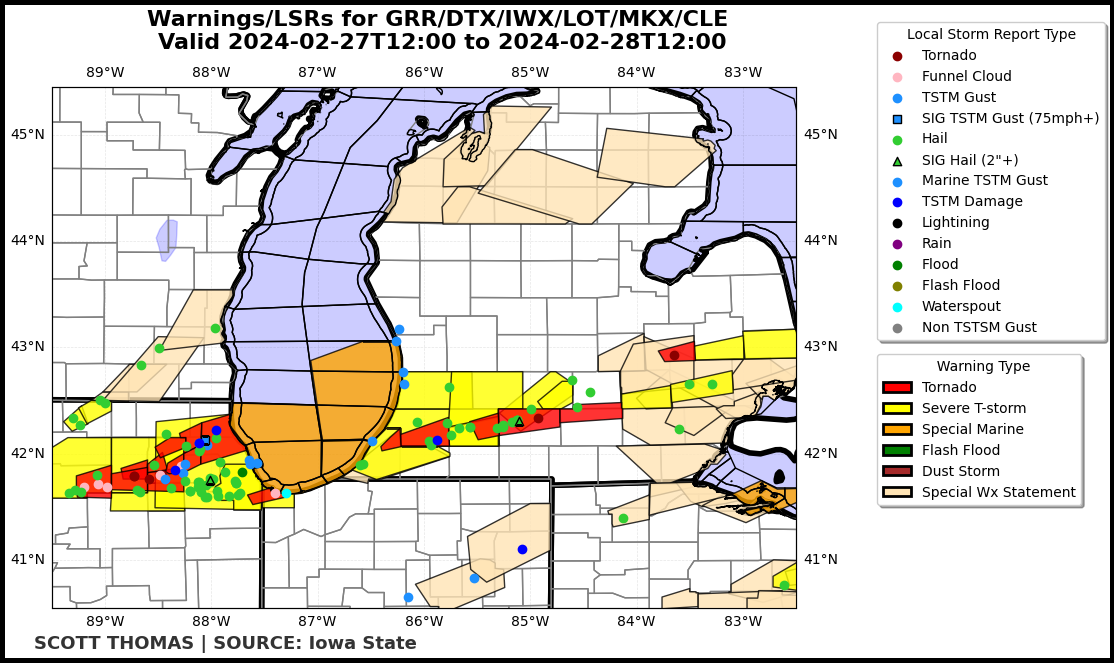

In [ ]:
# @title
fig = plt.figure(figsize=(12, 12), facecolor='white', edgecolor="black", linewidth =6)
ax=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent((WestLong, EastLong, SouthLat, NorthLat))
ax.set_box_aspect(0.7)
axb = ax.twinx()
axb.set_box_aspect(0.7)
#Add Geometries
try:
  ax.add_geometries(SPS.geometry, crs = ccrs.PlateCarree(), facecolor = '#FFE4B5', edgecolor = 'black',  zorder=993, alpha = 0.8)
except:
  pass
try:
  ax.add_geometries(TORWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  'red', edgecolor = 'black', zorder = 998, alpha = 0.8)
  ax.add_geometries(SVRWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  'yellow', edgecolor = 'black', zorder = 997, alpha = 0.8)
  ax.add_geometries(SMWWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  'orange', edgecolor = 'black', zorder = 996, alpha = 0.8)
  ax.add_geometries(FFWWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  'green', edgecolor = 'black', zorder = 995, alpha = 0.8)
  ax.add_geometries(DSWWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  'brown', edgecolor = 'black', zorder = 994, alpha = 0.8)
except:
  pass
try:
  ax.add_geometries(TORWarn2.geometry, crs = ccrs.PlateCarree(), facecolor =  'red', edgecolor = 'black', zorder = 998, alpha = 0.8)
  ax.add_geometries(SVRWarn2.geometry, crs = ccrs.PlateCarree(), facecolor =  'yellow', edgecolor = 'black', zorder = 997, alpha = 0.8)
  ax.add_geometries(SMWWarn2.geometry, crs = ccrs.PlateCarree(), facecolor =  'orange', edgecolor = 'black', zorder = 996, alpha = 0.8)
  ax.add_geometries(FFWWarn2.geometry, crs = ccrs.PlateCarree(), facecolor =  'green', edgecolor = 'black', zorder = 995, alpha = 0.8)
  ax.add_geometries(DSWWarn2.geometry, crs = ccrs.PlateCarree(), facecolor =  'brown', edgecolor = 'black', zorder = 994, alpha = 0.8)
except:
  pass
try:
  ax.add_geometries(TORWarn3.geometry, crs = ccrs.PlateCarree(), facecolor =  'red', edgecolor = 'black', zorder = 998, alpha = 0.8)
  ax.add_geometries(SVRWarn3.geometry, crs = ccrs.PlateCarree(), facecolor =  'yellow', edgecolor = 'black', zorder = 997, alpha = 0.8)
  ax.add_geometries(SMWWarn3.geometry, crs = ccrs.PlateCarree(), facecolor =  'orange', edgecolor = 'black', zorder = 996, alpha = 0.8)
  ax.add_geometries(FFWWarn3.geometry, crs = ccrs.PlateCarree(), facecolor =  'green', edgecolor = 'black', zorder = 995, alpha = 0.8)
  ax.add_geometries(DSWWarn3.geometry, crs = ccrs.PlateCarree(), facecolor =  'brown', edgecolor = 'black', zorder = 994, alpha = 0.8)
except:
  pass
try:
  ax.add_geometries(TORWarn4.geometry, crs = ccrs.PlateCarree(), facecolor =  'red', edgecolor = 'black', zorder = 998, alpha = 0.8)
  ax.add_geometries(SVRWarn4.geometry, crs = ccrs.PlateCarree(), facecolor =  'yellow', edgecolor = 'black', zorder = 997, alpha = 0.8)
  ax.add_geometries(SMWWarn4.geometry, crs = ccrs.PlateCarree(), facecolor =  'orange', edgecolor = 'black', zorder = 996, alpha = 0.8)
  ax.add_geometries(FFWWarn4.geometry, crs = ccrs.PlateCarree(), facecolor =  'green', edgecolor = 'black', zorder = 995, alpha = 0.8)
  ax.add_geometries(DSWWarn4.geometry, crs = ccrs.PlateCarree(), facecolor =  'brown', edgecolor = 'black', zorder = 994, alpha = 0.8)
except:
  pass

try:
  ax.add_geometries(TORWarn5.geometry, crs = ccrs.PlateCarree(), facecolor =  'red', edgecolor = 'black', zorder = 998, alpha = 0.8)
  ax.add_geometries(SVRWarn5.geometry, crs = ccrs.PlateCarree(), facecolor =  'yellow', edgecolor = 'black', zorder = 997, alpha = 0.8)
  ax.add_geometries(SMWWarn5.geometry, crs = ccrs.PlateCarree(), facecolor =  'orange', edgecolor = 'black', zorder = 996, alpha = 0.8)
  ax.add_geometries(FFWWarn5.geometry, crs = ccrs.PlateCarree(), facecolor =  'green', edgecolor = 'black', zorder = 995, alpha = 0.8)
  ax.add_geometries(DSWWarn5.geometry, crs = ccrs.PlateCarree(), facecolor =  'brown', edgecolor = 'black', zorder = 994, alpha = 0.8)
except:
  pass

try:
  ax.add_geometries(TORWarn6.geometry, crs = ccrs.PlateCarree(), facecolor =  'red', edgecolor = 'black', zorder = 998, alpha = 0.8)
  ax.add_geometries(SVRWarn6.geometry, crs = ccrs.PlateCarree(), facecolor =  'yellow', edgecolor = 'black', zorder = 997, alpha = 0.8)
  ax.add_geometries(SMWWarn6.geometry, crs = ccrs.PlateCarree(), facecolor =  'orange', edgecolor = 'black', zorder = 996, alpha = 0.8)
  ax.add_geometries(FFWWarn6.geometry, crs = ccrs.PlateCarree(), facecolor =  'green', edgecolor = 'black', zorder = 995, alpha = 0.8)
  ax.add_geometries(DSWWarn6.geometry, crs = ccrs.PlateCarree(), facecolor =  'brown', edgecolor = 'black', zorder = 994, alpha = 0.8)
except:
  pass
ax.add_geometries(MarZoneMap.geometry, crs = ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black',  zorder=999)


#Plot LSRs
ax.scatter(y = TORSR['LAT'], x = TORSR['LON'], zorder=999, color = 'darkred', label = 'Tornado')
ax.scatter(y = FNCSR['LAT'], x = FNCSR['LON'], zorder=999, color = 'lightpink', label = 'Funnel Cloud')
ax.scatter(y = TSGSR['LAT'], x = TSGSR['LON'], zorder=999, color = 'dodgerblue', label = 'TSTM Gust')
ax.scatter(y = SIGTSGSR['LAT'], x = SIGTSGSR['LON'], zorder=999, color = 'dodgerblue', label = 'SIG TSTM Gust (75mph+)', marker = 's', edgecolor = 'black')
ax.scatter(y = HALSR['LAT'], x = HALSR['LON'], zorder=999, color = 'limegreen', label = 'Hail')
ax.scatter(y = SIGHALSR['LAT'], x = SIGHALSR['LON'], zorder=999, color = 'limegreen', label = 'SIG Hail (2"+)', marker = '^', edgecolor = 'black')
ax.scatter(y = MTGSR['LAT'], x = MTGSR['LON'], zorder=999, color = 'dodgerblue', label = 'Marine TSTM Gust')
ax.scatter(y = TSDSR['LAT'], x = TSDSR['LON'], zorder=999, color = 'blue', label = 'TSTM Damage')
ax.scatter(y = LTGSR['LAT'], x = LTGSR['LON'], zorder=999, color = 'black', label = 'Lightining')
ax.scatter(y = RANSR['LAT'], x = RANSR['LON'], zorder=999, color = 'purple', label = 'Rain')
ax.scatter(y = FLDSR['LAT'], x = FLDSR['LON'], zorder=999, color = 'green', label = 'Flood')
ax.scatter(y = FFDSR['LAT'], x = FFDSR['LON'], zorder=999, color = 'olive', label = 'Flash Flood')
ax.scatter(y = WSTSR['LAT'], x = WSTSR['LON'], zorder=999, color = 'cyan', label = 'Waterspout')
ax.scatter(y = NTGSR['LAT'], x = NTGSR['LON'], zorder=999, color = 'gray', label = 'Non TSTSM Gust')

try:
  ax.scatter(y = TORSR2['LAT'], x = TORSR2['LON'], zorder=999, color = 'darkred')
  ax.scatter(y = FNCSR2['LAT'], x = FNCSR2['LON'], zorder=999, color = 'lightpink')
  ax.scatter(y = NTGSR2['LAT'], x = NTGSR2['LON'], zorder=999, color = 'gray')
  ax.scatter(y = TSGSR2['LAT'], x = TSGSR2['LON'], zorder=999, color = 'dodgerblue')
  ax.scatter(y = SIGTSGSR2['LAT'], x = SIGTSGSR2['LON'], zorder=999, color = 'dodgerblue', marker = 's', edgecolor = 'black')
  ax.scatter(y = HALSR2['LAT'], x = HALSR2['LON'], zorder=999, color = 'limegreen')
  ax.scatter(y = SIGHALSR2['LAT'], x = SIGHALSR2['LON'], zorder=999, color = 'limegreen', marker = '^', edgecolor = 'black')
  ax.scatter(y = TSDSR2['LAT'], x = TSDSR2['LON'], zorder=999, color = 'blue')
  ax.scatter(y = LTGSR2['LAT'], x = LTGSR2['LON'], zorder=999, color = 'black')
  ax.scatter(y = RANSR2['LAT'], x = RANSR2['LON'], zorder=999, color = 'purple')
  ax.scatter(y = FLDSR2['LAT'], x = FLDSR2['LON'], zorder=999, color = 'green')
  ax.scatter(y = FFDSR2['LAT'], x = FFDSR2['LON'], zorder=999, color = 'olive')
  ax.scatter(y = MTGSR2['LAT'], x = MTGSR2['LON'], zorder=999, color = 'dodgerblue')
  ax.scatter(y = WSTSR2['LAT'], x = WSTSR2['LON'], zorder=999, color = 'cyan')
except:
  pass

try:
  ax.scatter(y = TORSR3['LAT'], x = TORSR3['LON'], zorder=999, color = 'darkred')
  ax.scatter(y = FNCSR3['LAT'], x = FNCSR3['LON'], zorder=999, color = 'lightpink')
  ax.scatter(y = NTGSR3['LAT'], x = NTGSR3['LON'], zorder=999, color = 'gray')
  ax.scatter(y = TSGSR3['LAT'], x = TSGSR3['LON'], zorder=999, color = 'dodgerblue')
  ax.scatter(y = SIGTSGSR3['LAT'], x = SIGTSGSR3['LON'], zorder=999, color = 'dodgerblue', marker = 's', edgecolor = 'black')
  ax.scatter(y = HALSR3['LAT'], x = HALSR3['LON'], zorder=999, color = 'limegreen')
  ax.scatter(y = SIGHALSR3['LAT'], x = SIGHALSR3['LON'], zorder=999, color = 'limegreen', marker = '^', edgecolor = 'black')
  ax.scatter(y = TSDSR3['LAT'], x = TSDSR3['LON'], zorder=999, color = 'blue')
  ax.scatter(y = LTGSR3['LAT'], x = LTGSR3['LON'], zorder=999, color = 'black')
  ax.scatter(y = RANSR3['LAT'], x = RANSR3['LON'], zorder=999, color = 'purple')
  ax.scatter(y = FLDSR3['LAT'], x = FLDSR3['LON'], zorder=999, color = 'green')
  ax.scatter(y = FFDSR3['LAT'], x = FFDSR3['LON'], zorder=999, color = 'olive')
  ax.scatter(y = MTGSR3['LAT'], x = MTGSR3['LON'], zorder=999, color = 'dodgerblue')
  ax.scatter(y = WSTSR3['LAT'], x = WSTSR3['LON'], zorder=999, color = 'cyan')
except:
  pass

try:
  ax.scatter(y = TORSR4['LAT'], x = TORSR4['LON'], zorder=999, color = 'darkred')
  ax.scatter(y = FNCSR4['LAT'], x = FNCSR4['LON'], zorder=999, color = 'lightpink')
  ax.scatter(y = NTGSR4['LAT'], x = NTGSR4['LON'], zorder=999, color = 'gray')
  ax.scatter(y = TSGSR4['LAT'], x = TSGSR4['LON'], zorder=999, color = 'dodgerblue')
  ax.scatter(y = SIGTSGSR4['LAT'], x = SIGTSGSR4['LON'], zorder=999, color = 'dodgerblue', marker = 's', edgecolor = 'black')
  ax.scatter(y = HALSR4['LAT'], x = HALSR4['LON'], zorder=999, color = 'limegreen')
  ax.scatter(y = SIGHALSR4['LAT'], x = SIGHALSR4['LON'], zorder=999, color = 'limegreen', marker = '^', edgecolor = 'black')
  ax.scatter(y = TSDSR4['LAT'], x = TSDSR4['LON'], zorder=999, color = 'blue')
  ax.scatter(y = LTGSR4['LAT'], x = LTGSR4['LON'], zorder=999, color = 'black')
  ax.scatter(y = RANSR4['LAT'], x = RANSR4['LON'], zorder=999, color = 'purple')
  ax.scatter(y = FLDSR4['LAT'], x = FLDSR4['LON'], zorder=999, color = 'green')
  ax.scatter(y = FFDSR4['LAT'], x = FFDSR4['LON'], zorder=999, color = 'olive')
  ax.scatter(y = MTGSR4['LAT'], x = MTGSR4['LON'], zorder=999, color = 'dodgerblue')
  ax.scatter(y = WSTSR4['LAT'], x = WSTSR4['LON'], zorder=999, color = 'cyan')
except:
  pass

try:
  ax.scatter(y = TORSR5['LAT'], x = TORSR5['LON'], zorder=999, color = 'darkred')
  ax.scatter(y = FNCSR5['LAT'], x = FNCSR5['LON'], zorder=999, color = 'lightpink')
  ax.scatter(y = NTGSR5['LAT'], x = NTGSR5['LON'], zorder=999, color = 'gray')
  ax.scatter(y = TSGSR5['LAT'], x = TSGSR5['LON'], zorder=999, color = 'dodgerblue')
  ax.scatter(y = SIGTSGSR5['LAT'], x = SIGTSGSR5['LON'], zorder=999, color = 'dodgerblue', marker = 's', edgecolor = 'black')
  ax.scatter(y = HALSR5['LAT'], x = HALSR5['LON'], zorder=999, color = 'limegreen')
  ax.scatter(y = SIGHALSR5['LAT'], x = SIGHALSR5['LON'], zorder=999, color = 'limegreen', marker = '^', edgecolor = 'black')
  ax.scatter(y = TSDSR5['LAT'], x = TSDSR5['LON'], zorder=999, color = 'blue')
  ax.scatter(y = LTGSR5['LAT'], x = LTGSR5['LON'], zorder=999, color = 'black')
  ax.scatter(y = RANSR5['LAT'], x = RANSR5['LON'], zorder=999, color = 'purple')
  ax.scatter(y = FLDSR5['LAT'], x = FLDSR5['LON'], zorder=999, color = 'green')
  ax.scatter(y = FFDSR5['LAT'], x = FFDSR5['LON'], zorder=999, color = 'olive')
  ax.scatter(y = MTGSR5['LAT'], x = MTGSR5['LON'], zorder=999, color = 'dodgerblue')
  ax.scatter(y = WSTSR5['LAT'], x = WSTSR5['LON'], zorder=999, color = 'cyan')
except:
  pass

try:
  ax.scatter(y = TORSR6['LAT'], x = TORSR6['LON'], zorder=999, color = 'darkred')
  ax.scatter(y = FNCSR6['LAT'], x = FNCSR6['LON'], zorder=999, color = 'lightpink')
  ax.scatter(y = NTGSR6['LAT'], x = NTGSR6['LON'], zorder=999, color = 'gray')
  ax.scatter(y = TSGSR6['LAT'], x = TSGSR6['LON'], zorder=999, color = 'dodgerblue')
  ax.scatter(y = SIGTSGSR6['LAT'], x = SIGTSGSR6['LON'], zorder=999, color = 'dodgerblue', marker = 's', edgecolor = 'black')
  ax.scatter(y = HALSR6['LAT'], x = HALSR6['LON'], zorder=999, color = 'limegreen')
  ax.scatter(y = SIGHALSR6['LAT'], x = SIGHALSR6['LON'], zorder=999, color = 'limegreen', marker = '^', edgecolor = 'black')
  ax.scatter(y = TSDSR6['LAT'], x = TSDSR6['LON'], zorder=999, color = 'blue')
  ax.scatter(y = LTGSR6['LAT'], x = LTGSR6['LON'], zorder=999, color = 'black')
  ax.scatter(y = RANSR6['LAT'], x = RANSR6['LON'], zorder=999, color = 'purple')
  ax.scatter(y = FLDSR6['LAT'], x = FLDSR6['LON'], zorder=999, color = 'green')
  ax.scatter(y = FFDSR6['LAT'], x = FFDSR6['LON'], zorder=999, color = 'olive')
  ax.scatter(y = MTGSR6['LAT'], x = MTGSR6['LON'], zorder=999, color = 'dodgerblue')
  ax.scatter(y = WSTSR6['LAT'], x = WSTSR6['LON'], zorder=999, color = 'cyan')
except:
  pass

TORW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='red')
SMW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='orange')
SVRW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='yellow')
FFW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='green')
DSTW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='brown')
SPSW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='#FFE4B5')

axb.legend([TORW, SVRW, SMW, FFW, DSTW, SPSW], ['Tornado', 'Severe T-storm', 'Special Marine', 'Flash Flood', 'Dust Storm', 'Special Wx Statement'],
            loc='upper left', fontsize=10, facecolor='white', markerscale=8,
            labelcolor='k', title='  Warning Type', title_fontsize=10,
           bbox_to_anchor=(1.10, 0.5), fancybox=True, shadow=True,).set_zorder(10)

ax.coastlines(color='black',resolution='10m',zorder=99)
ax.add_feature(cfeat.STATES.with_scale('50m'),edgecolor='black', zorder=9, linewidth = 4)
ax.add_feature(USCOUNTIES, facecolor='None', edgecolor='gray', zorder=9)
lake = cfeat.NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='blue', facecolor='blue', alpha=0.2)
ax.add_feature(lake)
plt.figtext(0.11, 0.23, f'SCOTT THOMAS | SOURCE: Iowa State', weight='bold', color='black', fontsize=13, ha='left', alpha=0.8)
plt.figtext(0.45, 0.73, f'Warnings/LSRs for {WFO_List} \nValid {Begins} to {Ends}', ha='center', weight='bold', fontsize=16)
gl = ax.gridlines(draw_labels = True, x_inline = False, y_inline = False, rotate_labels = False, linewidth = 0.5, linestyle = '--', color = 'black', alpha = 0.1)
gl.x_labels_top = False
gl.x_labels_bottom = True
axb.grid(False)
axb.set_xticks([])
axb.set_yticks([])
box1 = ax.get_position()
ax.set_position([box1.x0, box1.y0, box1.width * 0.8, box1 .height*0.95])
ax.legend(loc='lower left', bbox_to_anchor=(1.10, 0.5),
    ncol=1, fancybox=True, shadow=True, title = 'Local Storm Report Type')
plt.savefig(f'WarningsLSRs{Ends}.png', bbox_inches = 'tight')

#Clear All Data To Avoid Extraneous Variables For Future Plots

In [ ]:
# @title
#Clear CWA 2/3/4 Warnings, SPSs, and LSRs for Additional Plots
try:
  del TORWarn, SVRWarn, FFWWarn, SMWWarn, DSWWarn
except:
  pass
try:
  del TORSR, FNCSR, LTGSR, RANSR, HALSR, TSDSR, TSGSR, FLDSR, FFDSR, NTGSR, SIGTSGSR, SIGHALSR
except:
  pass
try:
  del TORWarn2, SVRWarn2, FFWWarn2, SMWWarn2, DSWWarn2
except:
  pass
try:
  del TORSR2, FNCSR2, LTGSR2, RANSR2, HALSR2, TSDSR2, TSGSR2, FLDSR2, FFDSR2, NTGSR2, SIGTSGSR2, SIGHALSR2
except:
  pass
try:
  del TORWarn3, SVRWarn3, FFWWarn3, SMWWarn3, DSWWarn3
except:
  pass
try:
  del TORSR3, FNCSR3, LTGSR3, RANSR3, HALSR3, TSDSR3, TSGSR3, FLDSR3, FFDSR3, NTGSR3, SIGTSGSR3, SIGHALSR3
except:
  pass
try:
  del TORWarn4, SVRWarn4, FFWWarn4, SMWWarn4, DSWWarn4
except:
  pass
try:
  del TORSR4, FNCSR4, LTGSR4, RANSR4, HALSR4, TSDSR4, TSGSR4, FLDSR4, FFDSR4, NTGSR4, SIGTSGSR4, SIGHALSR4
except:
  pass
try:
  del TORWarn5, SVRWarn5, FFWWarn5, SMWWarn5, DSWWarn5
except:
  pass
try:
  del TORSR5, FNCSR5, LTGSR5, RANSR5, HALSR5, TSDSR5, TSGSR5, FLDSR5, FFDSR5, NTGSR5, SIGTSGSR5, SIGHALSR5
except:
  pass
try:
  del TORWarn6, SVRWarn6, FFWWarn6, SMWWarn6, DSWWarn6
except:
  pass
try:
  del TORSR5, FNCSR6, LTGSR6, RANSR6, HALSR6, TSDSR6, TSGSR6, FLDSR6, FFDSR6, NTGSR6, SIGTSGSR6, SIGHALSR6
except:
  pass
try:
  del SPS
except:
  pass
try:
  del SPSFile
except:
  pass